# Graph Convolutional Network(GCN) for Jet tagging using jet constituents from HLS data using node self weight indepent of neighbouring nodes weight

## Author: Andre Sznajder

 Text bellow extracted from https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html ( Graph Classification with Graph Neural Networks)

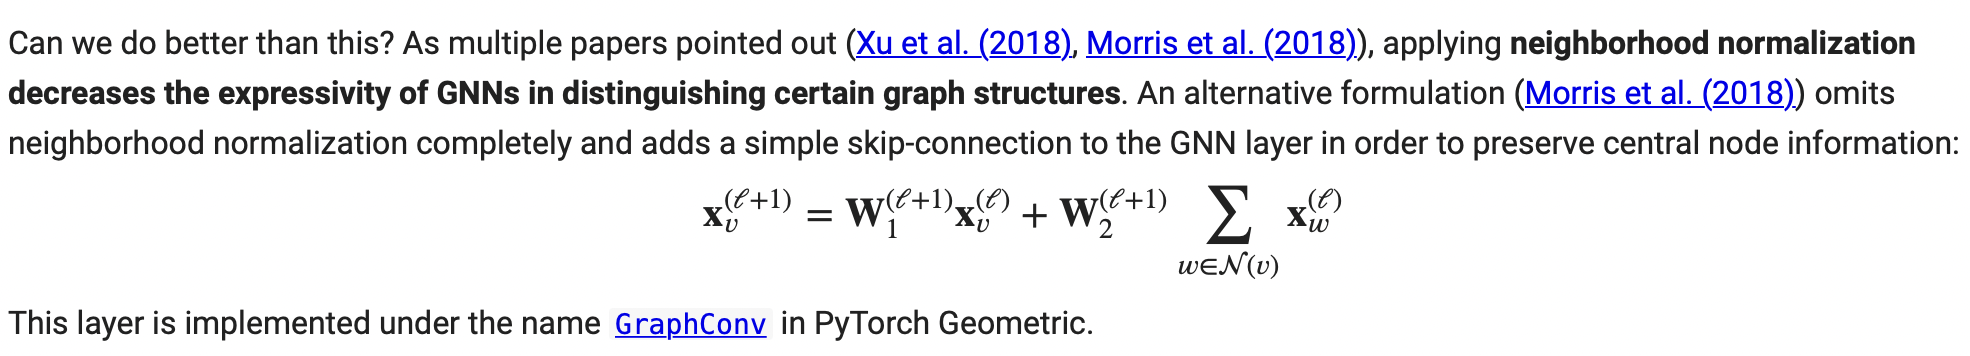


Implementation inspired by SPEKTRAL ( from T.Kipf original ) , but added node self weight as in PyTorch  :
https://graphneural.network/layers/convolution/#gcnconv


In [1]:
#!fusermount -u drive
#! pip install einops

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#data_dir = '/content/gdrive/My Drive/Colab Notebooks/Data/'


# Load HLS datasets

In [ ]:
import numpy as np
import h5py
import os

# for pT, eta_rel, phi_rel
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[5,8,11]])
# for px, py, pz
#   myJetConstituentList = np.array(f.get("jetConstituentList")[:,:,[0,1,2]])
#   myJetConstituentList = np.array(f.get("jetConstituentList"))
#
# Jet Constituents Features =  [0='j1_px', 1='j1_py', 2='j1_pz', 3='j1_e', 4='j1_erel', 5='j1_pt', 6='j1_ptrel',
#                         7='j1_eta', 8='j1_etarel', 9='j1_etarot', 10='j1_phi', 11='j1_phirel', 12='j1_phirot',
#                         13='j1_deltaR', 14='j1_costheta', 15='j1_costhetarel', 16='j1_pdgid']



#Data PATH
TRAIN_PATH = '/Users/sznajder/WorkM1/workdir/data/hls4ml_LHCjet_150p/'

# Prepare the DATA
#target = np.array([])
#jetConstituent = np.array([])
#jetImage = np.array([])

first=True
for file in os.listdir(TRAIN_PATH):
  print("Appending %s" %file)

  with h5py.File(TRAIN_PATH+file, 'r') as data:
    if first : 
        first=False
        jetConstituent = data['jetConstituentList'][:,:,[5,8,11]]  # 
#        jetImage= data['jetImage'][:,:,:] 
        target = data['jets'][:,-6:-1]
    
        print("Keys in H5PY files = ",list( data.keys() ))
        print(" ")
        featurenames = data.get('jetFeatureNames')
        print("Jets Features = ",featurenames[:])
        # the b is due to the byte vs utf-8 encoding of the strings in the dataset
        # just ignore them for the moment
        print(" ")
        featurenames = data.get('particleFeatureNames')
        print("Jet Constituents Features = ",featurenames[:])
        print(" ")
        images = data.get('jetImage')
        print("Jet Images = ",images[:])        
        print("Jet Image Shape = ",images.shape)   
        print(" ")

    else:
         # Read (Pt,Etarel,Phirel)
        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,8,11]] ] , axis=0 )
         # Read (Pt,Eta,Phi)
#        jetConstituent = np.concatenate( [ jetConstituent, data['jetConstituentList'][:,:,[5,7,10]] ] , axis=0 )
#        jetImage = np.concatenate( [ jetImage, data['jetImage']    ] , axis=0 )
        target   = np.concatenate( [ target, data['jets'][:,-6:-1] ] , axis=0 )


                                    
print("Target shape =", target.shape)
print("Jet Constituents shape =", jetConstituent.shape)
#print("Jet Image shape =", jetImage.shape)


Appending jetImage_6_150p_40000_50000.h5
Keys in H5PY files =  ['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']
 
Jets Features =  [b'j_ptfrac' b'j_pt' b'j_eta' b'j_mass' b'j_tau1_b1' b'j_tau2_b1'
 b'j_tau3_b1' b'j_tau1_b2' b'j_tau2_b2' b'j_tau3_b2' b'j_tau32_b1'
 b'j_tau32_b2' b'j_zlogz' b'j_c1_b0' b'j_c1_b1' b'j_c1_b2' b'j_c2_b1'
 b'j_c2_b2' b'j_d2_b1' b'j_d2_b2' b'j_d2_a1_b1' b'j_d2_a1_b2' b'j_m2_b1'
 b'j_m2_b2' b'j_n2_b1' b'j_n2_b2' b'j_tau1_b1_mmdt' b'j_tau2_b1_mmdt'
 b'j_tau3_b1_mmdt' b'j_tau1_b2_mmdt' b'j_tau2_b2_mmdt' b'j_tau3_b2_mmdt'
 b'j_tau32_b1_mmdt' b'j_tau32_b2_mmdt' b'j_c1_b0_mmdt' b'j_c1_b1_mmdt'
 b'j_c1_b2_mmdt' b'j_c2_b1_mmdt' b'j_c2_b2_mmdt' b'j_d2_b1_mmdt'
 b'j_d2_b2_mmdt' b'j_d2_a1_b1_mmdt' b'j_d2_a1_b2_mmdt' b'j_m2_b1_mmdt'
 b'j_m2_b2_mmdt' b'j_n2_b1_mmdt' b'j_n2_b2_mmdt' b'j_mass_trim'
 b'j_mass_mmdt' b'j_mass_prun' b'j_mass_sdb2' b'j_mass_sdm1'
 b'j_multiplicity' b'j_g' b'j_q' b'j_w' b'j_z' b'

# The image dataset

Jets can be converted to images considering the (&eta;, &phi;) plane, centered along the axis direction and binned.
In our case, we consider a square of 1.6x1.6 in size (because the jet size is R=0.8) binned in 100x100 equal-size 'cells'


# The ground truth is incorporated in the ['g', 'q', 'w', 'z', 't'] vector of boolean, taking the form
 
## [1, 0, 0, 0, 0] for gluons
 
## [0, 1, 0, 0, 0] for quarks
 
## [0, 0, 1, 0, 0] for Ws
 
## [0, 0, 0, 1, 0] for Zs
 
## [0, 0, 0, 0, 1] for tops

## This is what is called 'one-hot' encoding of a descrete label (typical of ground truth for classification problems)



In [ ]:
from einops import rearrange, reduce, repeat

# Convert target format from one-hot encoding to single neuron
#target = np.argmax(target, axis=1)

# 1st dim is jet image index
# 2nd dim is image eta bin
# 3rd dim is image phi bin
njet = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat = jetConstituent.shape[2]

print('Shape of jetConstituent =',jetConstituent.shape)
print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)

# Filter out constituents with Pt<2GeV
Ptmin =2. 
constituents = np.zeros((njet, nconstit, nfeat) , dtype=np.float32) 
ij=0
max_constit=0
for j in range(njet):
    ic=0
    for c in range(nconstit):
        if ( jetConstituent[j,c,0] < Ptmin ):
            continue
        constituents[ij,ic,:] = jetConstituent[j,c,:] 
        ic+=1
    if (ic > 0):
        if ic > max_constit: max_constit=ic
        target[ij,:]=target[j,:] # assosicate the correct target a given graph 
        ij+=1


# Resizes the jets constituents and target arrays        
jetConstituent = constituents[0:ij,0:max_constit,:]
target = target[0:ij,:]


# Restric the number of constituents to a maximum of NMAX
nmax = 8
jetConstituent = jetConstituent[:,0:nmax,:]

# The dataset is N_jets x N_constituents x N_features
njet     = jetConstituent.shape[0]
nconstit = jetConstituent.shape[1]
nfeat    = jetConstituent.shape[2]

print('Number of jets =',njet)
print('Number of constituents =',nconstit)
print('Number of features =',nfeat)


Shape of jetConstituent = (880000, 150, 3)
Number of jets = 880000
Number of constituents = 150
Number of features = 3
Number of jets = 880000
Number of constituents = 8
Number of features = 3


## Create the Adjacency Matrix for each Jet Image

In [5]:
from sklearn.neighbors import kneighbors_graph
import math

# Create Graphs from jet images with the following format
#
#  Adjacent matrix:  A[batch_size, num_nodes, num_nodes] (should be normalized in advance)
#  Features matrix:  X[batch_size, num_nodes, num_features]
#       


# Loop over jets to create a Graph Adjacency
A = []
X = []
Y = []
ng = 0

# Loop over jets
for constit in jetConstituent: 
   
    # Check if reached max # of requested graphs 
#    if (ng > ngmax): break
    ng += 1

    # Create an Adjacency matrix using KNN algorithm
#    k=4
    k=7


#    adj = kneighbors_graph(constit, k, mode="distance")
    adj = kneighbors_graph(constit, k)
    
    '''    
    # Define Edge freatures from adjacency matrix A
    n = len(constit)
    E = np.zeros((n,n))
    for index, x in np.ndenumerate(adj.toarray()):
        if x==0.0 : continue
        i=index[0]
        j=index[1]
        deta = constit[i,0] - constit[j,0]
        dphi = constit[i,1] - constit[j,1]
        dpt  = constit[i,2] - constit[j,2]
        # Define the edge weight as distance in EtaxPhi
        etamax = max(abs(constit[i,0]),abs(constit[j,0]))
        phimax = max(abs(constit[i,1]),abs(constit[j,1]))
        if ( etamax==0.0 or phimax==0.0 ) : 
            dr=999999.
        else: 
            dr=((deta/etamax)**2+(dphi/phimax)**2)  # BEST PERFORMING METRIC !!!
#            dr=math.sqrt(deta**2+dphi**2)  # 

        E[i,j] = math.exp(-dr)
#        E[i,j]=1/dr
    '''

# Append Adjacency matrix and Feature vector to list    
#    A.append(E)  # Create an adjacency matrix base on edge weights
    A.append(adj)
    X.append(constit)

# Define GRAPH tensors for the full dataset in BATCH MODE ( https://graphneural.network/data-modes )
# The tensor dimensions corresponds to the maximum graph size (max # nodes) x (# features)
ngraphs = len(jetConstituent) # Number of graphs ( number of jets )
ntargets = 5

XX = np.zeros((ngraphs, nconstit, nfeat) , dtype=np.float32) # node features 
YY = np.zeros((ngraphs, ntargets) , dtype=np.float32)             # target label
AA = np.zeros((ngraphs, nconstit, nconstit ) , dtype=np.float32)  # adjacency matrix 

# Loop over graphs to fill the input tensors ( with event # indexed by i ) 
for i in range(ngraphs):
  n_nodes = len(X[i])
  XX[i, 0:nconstit, 0:nfeat] = X[i] 
  YY[i, 0:ntargets] = target[i]
  AA[i, 0:nconstit, 0:nconstit] = A[i].todense()

# Uncoment bellow for a fully connected Adjacency Matrix
#AA = np.ones((ngraphs, nconstit, nconstit ) , dtype=np.float32)  # fully connected adjacency matrix
#for i in range(nconstit): AA[:,i,i] = 0  # sets 0's along diagonal to avoid node self-connections in adjacency matrix


del jetConstituent, target


print("AA Shape = ",AA.shape)
print("XX Shape = ",XX.shape)
print("YY Shape = ",YY.shape)

print("AA Shape[0] = ",AA.shape[0])
print("AA Shape[1] = ",AA.shape[1])
print("AA Shape[2] = ",AA.shape[2])

print("XX Shape[0] = ",XX.shape[0])
print("XX Shape[1] = ",XX.shape[1])
print("XX Shape[2] = ",XX.shape[2])

print("AA[0] = ",AA[0,:,:])



AA Shape =  (880000, 8, 8)
XX Shape =  (880000, 8, 3)
YY Shape =  (880000, 5)
AA Shape[0] =  880000
AA Shape[1] =  8
AA Shape[2] =  8
XX Shape[0] =  880000
XX Shape[1] =  8
XX Shape[2] =  3
AA[0] =  [[0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0.]]


## Dividing the data into testing and training dataset

We will split the data into two parts (one for training+validation and one for testing) 

In [6]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, A_train_val, A_test, Y_train_val, Y_test = train_test_split(XX, AA, YY, test_size=0.33, random_state=7)

#print(X_train_val.shape, X_test.shape, A_train_val.shape, A_test.shape, Y_train_val.shape, Y_test.shape)

print('number of G jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==0 ))
print('number of Q jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==1 ))
print('number of W jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==2 ))
print('number of Z jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==3 ))
print('number of T jets for training/validation: %i'%np.sum( np.argmax(Y_train_val, axis=1)==4 ))

print('number of G jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==0 ))
print('number of Q jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==1 ))
print('number of W jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==2 ))
print('number of Z jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==3 ))
print('number of T jets for testing: %i'%np.sum( np.argmax(Y_test, axis=1)==4 ))

number of G jets for training/validation: 118789
number of Q jets for training/validation: 114175
number of W jets for training/validation: 118845
number of Z jets for training/validation: 118615
number of T jets for training/validation: 119176
number of G jets for testing: 58463
number of Q jets for testing: 56504
number of W jets for testing: 58327
number of Z jets for testing: 58337
number of T jets for testing: 58769


## Define GCN Layer


In [7]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras.layers import Layer

##########################################################################
#
#    Self Recurrent Graph Convolutional Layer with trainable skip connection ( more expressive that Kipf GCN ) 
#    as it weights node and its neighbours features independently ( AXW1 + XW2 ) , giving more expressiveness.
#
#########################################################################

class GCN(Layer):

    def __init__( self, channels, activation=None, **kwargs ):
        super().__init__( GCN, **kwargs )
        self.channels = channels
        self.activation = activations.get(activation) 

    def build(self, input_shape):
        assert len(input_shape) >= 2
#        input_dim = input_shape[0][-1]
        input_dim = input_shape[1][-1]
        self.wgt1 = self.add_weight(
            shape=(input_dim, self.channels),
            name="wgt1"
        )
        # self-loop weights
        self.wgt2 = self.add_weight(
            shape=(input_dim, self.channels),
            name="wgt2"
        )
        self.bias = self.add_weight(
            shape=(self.channels,),
            name="bias"
        )

    def call(self, inputs):
        a, x = inputs
        
#        output = ops.modal_dot(a, output)
#        output = K.dot(a, output)
#        awx = K.dot(a, wx)

        xw1 = K.dot(x, self.wgt1)  # neighbouring node weights
        xw2 = K.dot(x, self.wgt2)  # self node weights

        axw1 = tf.matmul(a, xw1)
        axw = axw1 + xw2           # add node and neighbours weighted features (self reccurency)
        z = K.bias_add(axw, self.bias) 
        output = self.activation(z)
        return output

    def get_config(self):
        # Implement get_config to enable serialization. This is optional.
        base_config = super(GCN, self).get_config()
        config = {"channels": self.channels,
                  "activation":self.activation
                 }
        return dict(list(base_config.items()) + list(config.items()))


In [8]:
# baseline keras model
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import Input, Activation, Dense, Dropout, Flatten , BatchNormalization, MaxPool1D
from tensorflow.keras import utils

# Define GCN network 

# Instantiate Tensorflow input tensors in Batch mode 
X = Input(shape=(nconstit, nfeat), name="X")
A = Input(shape=(nconstit, nconstit), sparse=False, name="A") 

print("X type=",type(X))
print("A type=",type(A))
print("X shape=",X.shape)
print("A shape=",A.shape)

H = BatchNormalization(name='batchnorm_1')(X)


# GCN Model

'''
# Config for 32 constituents
H = GCN(channels=nfeat*8, activation="relu")([A,H])  
H = GCN(channels=nfeat*4, activation="relu")([A,H])
nhidden = int(nconstit*nfeat/8)
'''

'''
# Config for 16 constituents
H = GCN(channels=nfeat*8, activation="relu")([A,H])  
H = GCN(channels=nfeat*4, activation="relu")([A,H])
nhidden = int(nconstit*nfeat/8)
'''

#'''
# Config for 8 constituents
#H = GCN(channels=nfeat*7, activation="relu")([A,H])   
H = GCN(channels=36, activation="relu")([A,H])
nhidden = int(nconstit*nfeat*0.6)
#'''

H = Flatten()(H)
H = Dense(nhidden, activation="relu")(H)
H = Dense(nhidden, activation="relu")(H)
H = Dense(nhidden, activation="relu")(H)


O = Dense(ntargets, activation="softmax") (H)

# Build the model
model = Model(inputs=[A,X], outputs=O)

# Define the optimizer ( minimization algorithm )
#optim = SGD(learning_rate=0.0001,decay=1e-6)
#optim = Adam(learning_rate=0.0005)
optim = Adam(learning_rate=0.0001)
#optim = Adam()


# Compile the Model
#model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# print the model summary
model.summary()


X type= <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
A type= <class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>
X shape= (None, 8, 3)
A shape= (None, 8, 8)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 8, 3)]       0                                            
__________________________________________________________________________________________________
A (InputLayer)                  [(None, 8, 8)]       0                                            
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 8, 3)         12          X[0][0]                          
__________________________________________________________________________________________________
g

## Run training
Here, we run the training.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# early stopping callback
es = EarlyStopping(monitor='val_categorical_accuracy', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.2, patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into mlp_model.h5
chkp = ModelCheckpoint('GCN_model.h5', monitor='val_categorical_accuracy', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

#tb = TensorBoard("/Users/sznajder/WorkM1/miniforge3/tensorflow_macos/arm64/workdir/logs")

# Train classifier
history = model.fit(  [A_train_val, X_train_val] , Y_train_val, 
                    epochs=200, 
                    batch_size=512, 
                    verbose=1,
                    callbacks=[es,ls], 
                    validation_split=0.3 )
                    
#                    callbacks=[early_stopping, model_checkpoint], 
                    

Epoch 1/200
807/807 [==============================] - 2s 3ms/step - loss: 1.4854 - categorical_accuracy: 0.3446 - val_loss: 1.4013 - val_categorical_accuracy: 0.4172
Epoch 2/200
807/807 [==============================] - 2s 2ms/step - loss: 1.3262 - categorical_accuracy: 0.4528 - val_loss: 1.2742 - val_categorical_accuracy: 0.4717
Epoch 3/200
807/807 [==============================] - 1s 2ms/step - loss: 1.2292 - categorical_accuracy: 0.4893 - val_loss: 1.2030 - val_categorical_accuracy: 0.5034
Epoch 4/200
807/807 [==============================] - 2s 2ms/step - loss: 1.1790 - categorical_accuracy: 0.5155 - val_loss: 1.1676 - val_categorical_accuracy: 0.5220
Epoch 5/200
807/807 [==============================] - 2s 2ms/step - loss: 1.1518 - categorical_accuracy: 0.5302 - val_loss: 1.1446 - val_categorical_accuracy: 0.5346
Epoch 6/200
807/807 [==============================] - 2s 2ms/step - loss: 1.1315 - categorical_accuracy: 0.5412 - val_loss: 1.1267 - val_categorical_accuracy: 0.546

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

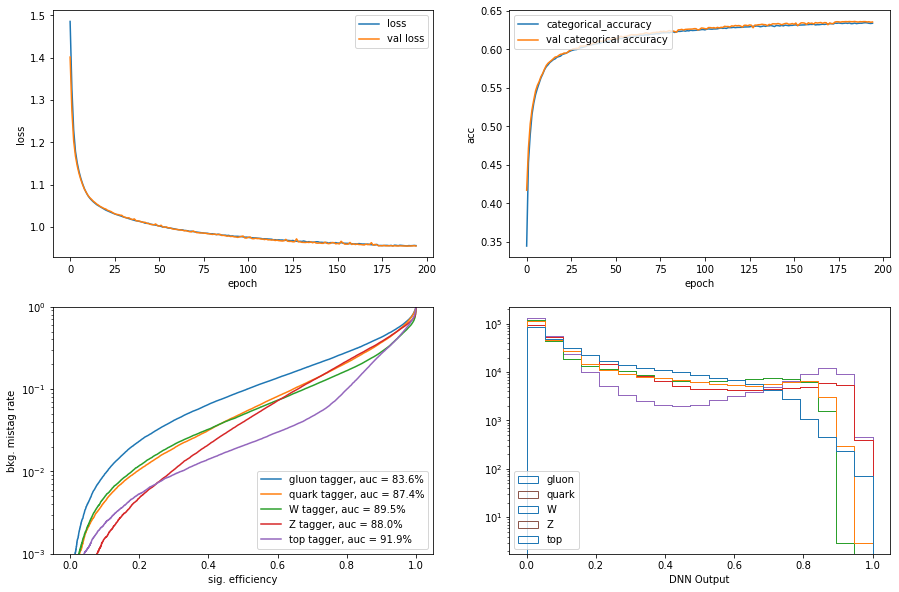

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


#plt.rcParams['axes.unicode_minus'] = False

# Plot loss vs epoch
plt.figure(figsize=(15,10))
ax = plt.subplot(2, 2, 1)
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val loss')
ax.legend(loc="upper right")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

# Plot accuracy vs epoch
ax = plt.subplot(2, 2, 2)
#ax.plot(history.history['accuracy'], label='accuracy')
#ax.plot(history.history['val_accuracy'], label='val accuracy')
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val categorical accuracy')
ax.legend(loc="upper left")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')

# Plot the ROC curves
labels = ['gluon', 'quark', 'W', 'Z', 'top']
fpr = {}
tpr = {}
auc1 = {}
ax = plt.subplot(2, 2, 3)
Y_predict = model.predict([A_test,X_test])
for i, label in enumerate(labels):
        fpr[label], tpr[label], threshold = roc_curve(Y_test[:,i], Y_predict[:,i])
        auc1[label] = auc(fpr[label], tpr[label])
        ax.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
ax.semilogy()
ax.set_xlabel("sig. efficiency")
ax.set_ylabel("bkg. mistag rate")
ax.set_ylim(0.001,1)
#ax.set_grid(True)
ax.legend(loc='lower right')
#plt.savefig('%s/ROC.pdf'%(options.outputDir))



# Plot DNN output 
ax = plt.subplot(2, 2, 4)
X = np.linspace(0.0, 1.0, 20)
hist={}
for i, name in enumerate(labels):
    hist[name] = ax.hist(Y_predict, bins=X, label=name ,histtype='step')
ax.semilogy()
ax.set_xlabel('DNN Output')
ax.legend(prop={'size': 10})
ax.legend(loc='lower left')
# Display plots
plt.show()


In [11]:

# Save FPR for a given TPR value ( 30% , 50% & 80%)
model = 'GCN'
with open('performance_'+model+'_nconst_'+str(nmax)+'.csv', 'w') as file:
  file.write("model,label,treshold,tpr,fpr\n")
  for label in labels:
    for t in [0.3, 0.5, 0.8]:
      index = np.argmax(tpr[label]>t)
      file.write( model+','+label+','+str(t)+','+str(tpr[label][index])+','+str(fpr[label][index])+'\n' )
      print("Label = ", label , " with treshold = ",t)
      print("TPR = ",tpr[label][index])
      print("FPR = ",fpr[label][index])
      print(" ")
 

Label =  gluon  with treshold =  0.3
TPR =  0.3000017104835537
FPR =  0.041696667629571825
 
Label =  gluon  with treshold =  0.5
TPR =  0.5000085524177685
FPR =  0.09528880687428051
 
Label =  gluon  with treshold =  0.8
TPR =  0.8000273677368592
FPR =  0.2802485157607454
 
Label =  quark  with treshold =  0.3
TPR =  0.3000672518759734
FPR =  0.01913243492834422
 
Label =  quark  with treshold =  0.5
TPR =  0.5000353957241965
FPR =  0.05154427608851797
 
Label =  quark  with treshold =  0.8
TPR =  0.8000318561517769
FPR =  0.20915706125799502
 
Label =  W  with treshold =  0.3
TPR =  0.30003257496528196
FPR =  0.021161444890185416
 
Label =  W  with treshold =  0.5
TPR =  0.5000085723592848
FPR =  0.049006131691321266
 
Label =  W  with treshold =  0.8
TPR =  0.8000068578874278
FPR =  0.16721462643220023
 
Label =  Z  with treshold =  0.3
TPR =  0.30004971116101276
FPR =  0.010454057734322146
 
Label =  Z  with treshold =  0.5
TPR =  0.5000085708898298
FPR =  0.03974782709867579
 
Lab